# Fukuchi (2018) - Import and process

This notebook details how the data from [Fukuchi et al. (2018)](https://peerj.com/articles/4640/) were imported and processed.

The data considered in this study are available in the `./Data/Fukuchi2018` directory of this repository. These data files are redistributed here under the terms of a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license. The original, full dataset is available on [figshare.com](https://figshare.com/articles/dataset/A_public_data_set_of_overground_and_treadmill_walking_kinematics_and_kinetics_of_healthy_individuals/5722711)

The attached "processed.npz" file contains processed versions of the four main .txt files and is similarly released under the terms of a "CC BY 4.0" License.

**References**:

Fukuchi, C. A., Fukuchi, R. K., & Duarte, M. (2018). A public dataset of overground and treadmill walking kinematics and kinetics in healthy individuals. PeerJ, 6, e4640.




In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

<br>
<br>

### Define processing functions:

In [2]:
def _butter(data, cutoff, hz, order=5, padtype=None, padlen=None, btype='lowpass'):
    '''
    Apply a lowpass butterworth filter.
    
    See scipy.signal.butter and scipy.signal.filtfilt
    '''
    from scipy.signal import butter, filtfilt
    nyq  = 0.5 * hz
    cut  = cutoff / nyq
    b,a  = butter(order, cut, btype=btype)
    y    = np.asarray(data)
    if y.ndim==1:
        y    = filtfilt(b, a, y, padtype=padtype, padlen=padlen)
    else:
        y    = np.array([filtfilt(b, a, yy, padtype=padtype, padlen=padlen)   for yy in y.T]).T
    return y	


def _segment_single(y, b):
    '''
    Segment a single cycle based on an initial approximate boolean array.
    This function walks back from the start of b to find the segment start,
    then walks forward from the end of b to find the segment end.

    Inputs:

    y: time series

    b: boolean array identifying approximate cycle span

    Returns:

    i0,i1: indices for the start and end of the segment
    '''
    nframes = y.shape[0]
    i0,i1   = np.argwhere( b ).ravel()[[0,-1]]
    # walk-back to start
    ii    = i0
    while (ii>=0) and (y[ii-1] < y[ii]):
        ii -= 1
    if i0==0:
        return None,None
    # walk-forward to end
    ii    = i1
    while (i1<nframes-1) and (y[ii+1] < y[ii]):
        ii += 1
    if i1>=nframes-1:
        return None,None
    return i0, i1
	

def _segment(f, fs, th=50):
    '''
    Segment cyclical time series based on an approximate threshold.

    Inputs:

    f: original (noisy) time series

    fs: smoothed time series

    th: approximate threshold for identifying the cycle start and end
    
    Returns:
    
    c: cycle labels;  (N,) array of int where N is the length of the original time series

    ind: cycle start-and-end indices;  (n,2) array of int
    '''
    
    from scipy.ndimage import label
    fy,fys  = f[:,1], fs[:,1]
    L,n     = label( fys > th )
    c       = np.zeros( f.shape[0], dtype=int )
    ind     = []
    cn      = 0
    for i in range(n):
        b     = L==(i+1)
        i0,i1 = _segment_single( fy, b )
        if i0 is not None:
            cn += 1
            c[i0:i1+1] = cn
            ind.append( (i0,i1) )
    return c, np.array(ind)


def _process(y, hz=300, cutoff=20, th=30):
    '''
    Process GRF data using the _butter and _segment functions above.

    Inputs:

    y: original (noisy) GRF data

    hz: sampling frequency

    cutoff: lowpass Butterworth filter cutoff frequency

    th: approximate threshold (N) for identifying segments (i.e., foot contacts)
    
    Returns:

    t: time vector;  (N,) array of int where N is the length of the original time series
    
    ys: smoothed GRF data
    
    c: cycle labels;  (N,) array of int where N is the length of the original time series
    '''
    t       = np.arange( y.shape[0] ) / hz
    ys      = _butter(y, cutoff, hz)
    c,ind   = _segment( y, ys, th=th )
    return t,ys,c

<br>
<br>

### Process and plot a single file:

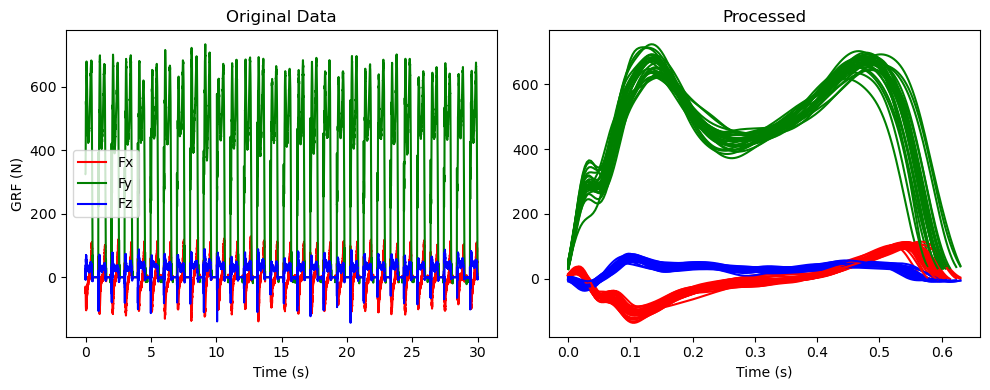

In [3]:
# load data:
dirDATA = os.path.join(   os.path.split( os.getcwd() )[0],   'Data'   )
speed   = 5
fpath   = os.path.join(dirDATA, 'Fukuchi2018', f'WBDS04walkT{speed:02}grf.txt')
a       = np.loadtxt(fpath, delimiter='\t', skiprows=1)


# extract left-foot GRF and process:
grf     = a[:,[1,2,3]]  # left foot GRF
hz      = 300           # sampling rate
t,y,c   = _process( grf, hz=hz, cutoff=20, th=30 )  # see processing function details above


# plot:
fig,axs = plt.subplots( 1, 2, figsize=(10,4), tight_layout=True )
colors  = 'r', 'g', 'b'
[axs[0].plot(t, yy, color=col) for yy,col in zip(grf.T, colors)]
for i in range(c.max()):
    yy = y[c==(i+1)]
    tt = np.arange( yy.shape[0] ) / hz
    [axs[1].plot(tt, yyy, color=col) for yyy,col in zip(yy.T, colors)]
[ax.set_xlabel('Time (s)')  for ax in axs]
axs[0].set_ylabel('GRF (N)')
axs[0].legend(['Fx', 'Fy', 'Fz'])
[ax.set_title(s)  for ax,s in zip(axs, ['Original Data', 'Processed'])]
plt.show()

<br>
<br>

### Import all four data files:


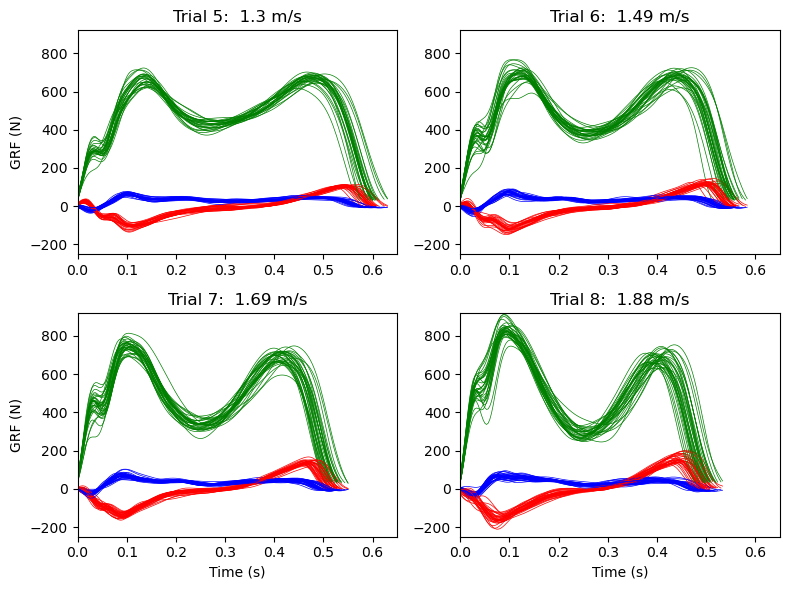

In [4]:
speeds      = [5, 6, 7, 8]             # speed indices
speeds_ms   = [1.3, 1.49, 1.69, 1.88]  # speeds in (m/s)
y,c         = [], []
for speed in speeds:
    fpath   = os.path.join(dirDATA, 'Fukuchi2018', f'WBDS04walkT{speed:02}grf.txt')
    grf     = np.loadtxt(fpath, delimiter='\t', skiprows=1)[:,[1,2,3]]
    _,yy,cc = _process( grf, hz=300, cutoff=20, th=30 )
    y.append( yy )
    c.append( cc )
y,c         = np.asarray(y), np.asarray(c)


# save (commented out here to avoid over-writing)
# fpath1    = os.path.join(dirDATA, 'Fukuchi2018', 'processed.npz')
# np.savez_compressed(fpath1, y=y, c=c)


# plot:
fig,axs = plt.subplots( 2, 2, figsize=(8,6), tight_layout=True )
for ax,yy,cc,ss,sm in zip(axs.ravel(), y, c, speeds, speeds_ms):
    for i in range(c.max()):
        yyy = yy[cc==(i+1)]
        ttt = np.arange( yyy.shape[0] ) / hz
        [ax.plot(ttt, yyyy, color=col, lw=0.5) for yyyy,col in zip(yyy.T, colors)]
    ax.set_title( f'Trial {ss}:  {sm} m/s' )
[ax.set_xlabel('Time (s)')  for ax in axs[1]]
[ax.set_ylabel('GRF (N)')  for ax in axs[:,0]]
plt.setp(axs, xlim=(0, 0.65), ylim=(-250, 920))
plt.show()